In [1]:
import uproot
import pandas as pd

# File paths (update with actual paths)
data_file_path = "/home/tlux/WCTE/DataAnalysis/AnalysisData/WCTE_offline_R1670S0_211.root"
mc_file_path = "/home/tlux/WCTE/DataAnalysis/AnalysisData/pi+_350MeVc_1000evts_masked.root"

# Tree name
tree_name = "WCTEReadoutWindows"

# Number of events to read
N_EVENTS = 3000

# Open trees
data_tree = uproot.open(f"{data_file_path}:{tree_name}")
mc_tree = uproot.open(f"{mc_file_path}:{tree_name}")

# List of branches to read (all by default)
branches_to_read = data_tree.keys()

# Read limited entries into awkward arrays
df_data = data_tree.arrays(entry_stop=N_EVENTS, library="ak")
df_mc = mc_tree.arrays(entry_stop=N_EVENTS, library="ak")

# Quick check
print("Data events:", len(df_data))
print("MC events:", len(df_mc))

Data events: 3000
MC events: 3000


In [2]:
# Access a single branch (e.g. event_number)
df_data["event_number"]  # or df_data.event_number



<Array [8, 10, 14, 16, 25, 1, ..., 154, 189, 203, 206, 211] type='3000 * int32'>

In [3]:
print(df_data.fields)

['window_time', 'start_counter', 'run_id', 'sub_run_id', 'spill_counter', 'event_number', 'readout_number', 'trigger_types', 'trigger_times', 'led_gains', 'led_dacsettings', 'led_ids', 'led_card_ids', 'led_slot_numbers', 'led_event_types', 'led_types', 'led_sequence_numbers', 'led_counters', 'hit_mpmt_card_ids', 'hit_pmt_channel_ids', 'hit_mpmt_slot_ids', 'hit_pmt_position_ids', 'hit_pmt_charges', 'hit_pmt_times', 'pmt_waveform_mpmt_card_ids', 'pmt_waveform_pmt_channel_ids', 'pmt_waveform_mpmt_slot_ids', 'pmt_waveform_pmt_position_ids', 'pmt_waveform_times', 'pmt_waveforms', 'beamline_pmt_qdc_charges', 'beamline_pmt_tdc_times', 'beamline_pmt_qdc_ids', 'beamline_pmt_tdc_ids', 'PDG']


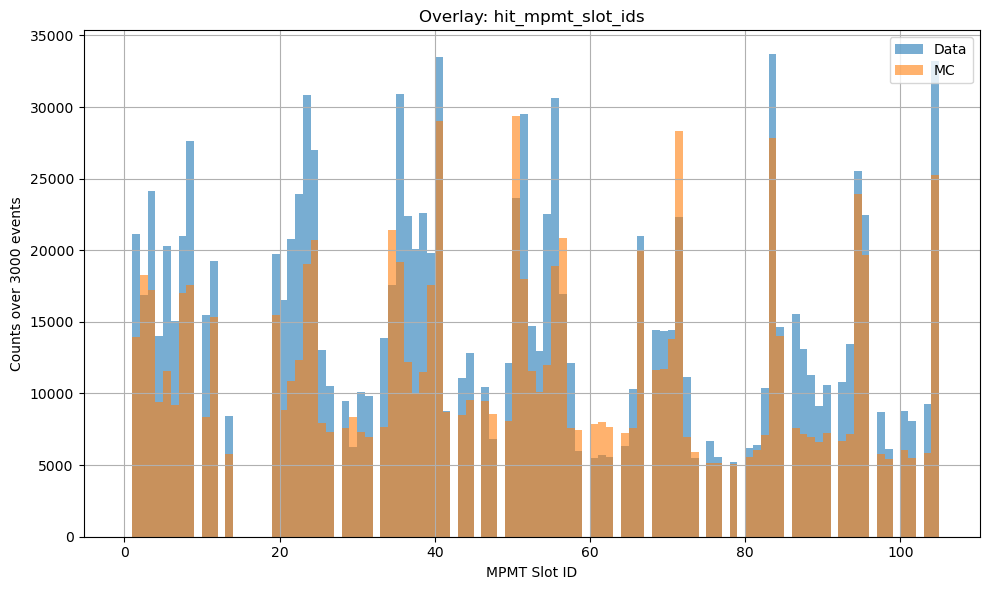

In [4]:
import matplotlib.pyplot as plt
import awkward as ak

# Flatten to get all hit slot IDs across all events
data_slot_ids = ak.flatten(df_data["hit_mpmt_slot_ids"])
mc_slot_ids = ak.flatten(df_mc["hit_mpmt_slot_ids"])

# Plot
plt.figure(figsize=(10, 6))
bins = range(0,
             max(ak.max(data_slot_ids), ak.max(mc_slot_ids)) + 1)

plt.hist(data_slot_ids, bins=bins, alpha=0.6, label="Data", histtype='stepfilled')
plt.hist(mc_slot_ids, bins=bins, alpha=0.6, label="MC", histtype='stepfilled')

plt.xlabel("MPMT Slot ID")
plt.ylabel("Counts over 3000 events")
plt.title("Overlay: hit_mpmt_slot_ids")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



In [5]:
# Flatten jagged arrays to 1D
data_slot_ids = ak.flatten(df_data["hit_mpmt_slot_ids"])
mc_slot_ids = ak.flatten(df_mc["hit_mpmt_slot_ids"])

# Convert to sets (removes duplicates)
data_slots_set = set(data_slot_ids)
mc_slots_set = set(mc_slot_ids)

# Find exclusive entries
in_data_only = sorted(data_slots_set - mc_slots_set)
in_mc_only = sorted(mc_slots_set - data_slots_set)

print("Slot IDs in Data only (not in MC):", in_data_only)
print("Slot IDs in MC only (not in Data):", in_mc_only)


Slot IDs in Data only (not in MC): [-1]
Slot IDs in MC only (not in Data): []


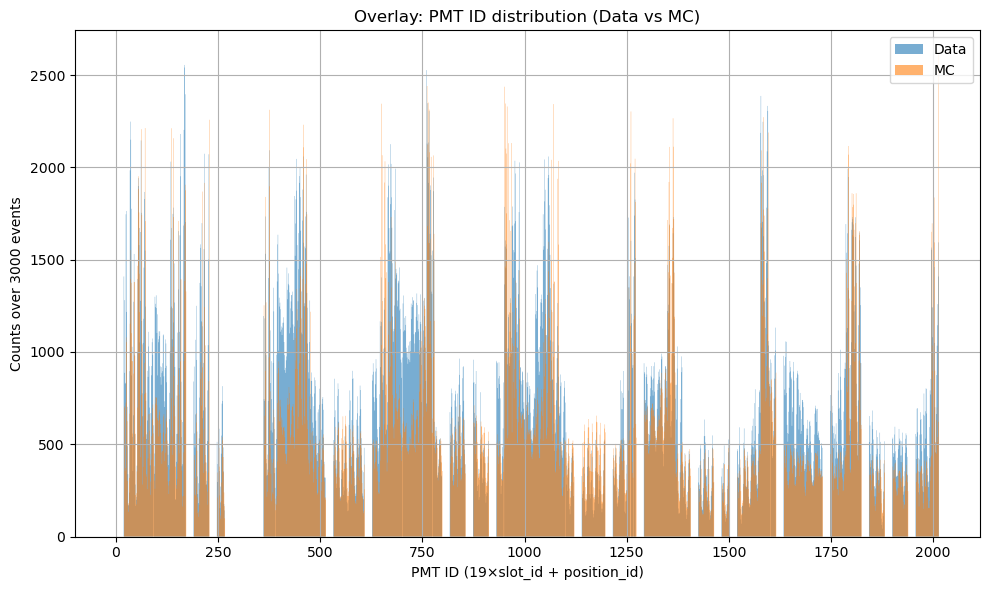

PMT IDs in Data only (not in MC): [-21, 19, 190, 247, 361, 532, 627, 817, 874, 931, 1140, 1216, 1292, 1425, 1482, 1520, 1634, 1748, 1843, 1900, 1957]
PMT IDs in MC only (not in Data): [91, 171, 228, 266, 390, 513, 608, 701, 774, 798, 855, 912, 949, 1099, 1121, 1197, 1258, 1259, 1266, 1272, 1273, 1406, 1463, 1501, 1602, 1615, 1729, 1824, 1881, 1938, 2014]


In [6]:
import matplotlib.pyplot as plt
import awkward as ak

# Flatten slot_id and channel_id arrays
data_slots = ak.flatten(df_data["hit_mpmt_slot_ids"])
data_channels = ak.flatten(df_data["hit_pmt_channel_ids"])
data_positions = ak.flatten(df_data["hit_pmt_position_ids"])
mc_slots = ak.flatten(df_mc["hit_mpmt_slot_ids"])
mc_channels = ak.flatten(df_mc["hit_pmt_channel_ids"])
mc_positions = ak.flatten(df_mc["hit_pmt_position_ids"])


# Compute PMT IDs
data_pmt_ids = 19 * data_slots + data_positions
mc_pmt_ids = 19 * mc_slots + mc_positions

# Plot overlay histogram
plt.figure(figsize=(10, 6))
bins = range(0,
             max(ak.max(data_pmt_ids), ak.max(mc_pmt_ids)) + 1)

plt.hist(data_pmt_ids, bins=bins, alpha=0.6, label="Data", histtype='stepfilled')
plt.hist(mc_pmt_ids, bins=bins, alpha=0.6, label="MC", histtype='stepfilled')

plt.xlabel("PMT ID (19×slot_id + position_id)")
plt.ylabel("Counts over 3000 events")
plt.title("Overlay: PMT ID distribution (Data vs MC)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Find exclusive PMT IDs
data_pmt_set = set(data_pmt_ids)
mc_pmt_set = set(mc_pmt_ids)

in_data_only = sorted(data_pmt_set - mc_pmt_set)
in_mc_only = sorted(mc_pmt_set - data_pmt_set)

print("PMT IDs in Data only (not in MC):", in_data_only)
print("PMT IDs in MC only (not in Data):", in_mc_only)


In [7]:
# Function to convert pmt_id back to (slot_id, channel_id)
def decode_pmt_ids(pmt_ids):
    return [(pid, pid // 19, pid % 19) for pid in sorted(pmt_ids)]

# Decode exclusive IDs
in_data_only_detailed = decode_pmt_ids(data_pmt_set - mc_pmt_set)
in_mc_only_detailed = decode_pmt_ids(mc_pmt_set - data_pmt_set)

# Print results
print("PMT IDs in Data only (not in MC):")
for pid, slot, ch in in_data_only_detailed:
    print(f"  pmt_id = {pid:4}, slot_id = {slot:2}, channel_id = {ch:2}")

print("\nPMT IDs in MC only (not in Data):")
for pid, slot, ch in in_mc_only_detailed:
    print(f"  pmt_id = {pid:4}, slot_id = {slot:2}, channel_id = {ch:2}")


PMT IDs in Data only (not in MC):
  pmt_id =  -21, slot_id = -2, channel_id = 17
  pmt_id =   19, slot_id =  1, channel_id =  0
  pmt_id =  190, slot_id = 10, channel_id =  0
  pmt_id =  247, slot_id = 13, channel_id =  0
  pmt_id =  361, slot_id = 19, channel_id =  0
  pmt_id =  532, slot_id = 28, channel_id =  0
  pmt_id =  627, slot_id = 33, channel_id =  0
  pmt_id =  817, slot_id = 43, channel_id =  0
  pmt_id =  874, slot_id = 46, channel_id =  0
  pmt_id =  931, slot_id = 49, channel_id =  0
  pmt_id = 1140, slot_id = 60, channel_id =  0
  pmt_id = 1216, slot_id = 64, channel_id =  0
  pmt_id = 1292, slot_id = 68, channel_id =  0
  pmt_id = 1425, slot_id = 75, channel_id =  0
  pmt_id = 1482, slot_id = 78, channel_id =  0
  pmt_id = 1520, slot_id = 80, channel_id =  0
  pmt_id = 1634, slot_id = 86, channel_id =  0
  pmt_id = 1748, slot_id = 92, channel_id =  0
  pmt_id = 1843, slot_id = 97, channel_id =  0
  pmt_id = 1900, slot_id = 100, channel_id =  0
  pmt_id = 1957, slot_id 

In [8]:
# Unique sets (already computed earlier)
data_pmt_set = set(data_pmt_ids)
mc_pmt_set = set(mc_pmt_ids)

# Intersections
common_pmt_ids = data_pmt_set & mc_pmt_set

# Print counts
print(f"Unique PMT IDs in Data:     {len(data_pmt_set)}")
print(f"Unique PMT IDs in MC:       {len(mc_pmt_set)}")
print(f"Shared PMT IDs (Data & MC): {len(common_pmt_ids)}")
print(f"Only in Data:               {len(data_pmt_set - mc_pmt_set)}")
print(f"Only in MC:                 {len(mc_pmt_set - data_pmt_set)}")


Unique PMT IDs in Data:     1548
Unique PMT IDs in MC:       1558
Shared PMT IDs (Data & MC): 1527
Only in Data:               21
Only in MC:                 31


In [9]:
import numpy as np
import awkward as ak
from collections import defaultdict

# Constants
MAX_SLOT_ID = 110  # Explicit upper bound for slot IDs
BINS = 4000        # 1 ns resolution
TIME_RANGE = (0, 4000)

# Initialize output arrays
data_peak_times = np.full(MAX_SLOT_ID, np.nan)
mc_peak_times = np.full(MAX_SLOT_ID, np.nan)

# --- DATA ---

# Flatten and group per slot
slots_data = ak.flatten(df_data["hit_mpmt_slot_ids"])
times_data = ak.flatten(df_data["hit_pmt_times"])

slot_time_map = defaultdict(list)
for slot, time in zip(slots_data, times_data):
    if 0 <= slot < MAX_SLOT_ID and time < TIME_RANGE[1]:
        slot_time_map[slot].append(time)

# Compute histogram-based peak
for slot, times in slot_time_map.items():
    if len(times) < 10:
        continue
    hist, bin_edges = np.histogram(times, bins=BINS, range=TIME_RANGE)
    peak_bin = np.argmax(hist)
    peak_time = bin_edges[peak_bin]  # left edge of the bin
    data_peak_times[slot] = peak_time

# --- MC ---

slots_mc = ak.flatten(df_mc["hit_mpmt_slot_ids"])
times_mc = ak.flatten(df_mc["hit_pmt_times"])

if len(slots_mc) > 0:
    example_slot = slots_mc[0]
    times_for_slot = [
        time for slot, time in zip(slots_mc, times_mc)
        if slot == example_slot and time < TIME_RANGE[1]
    ]

    if len(times_for_slot) >= 10:
        hist, bin_edges = np.histogram(times_for_slot, bins=BINS, range=TIME_RANGE)
        peak_bin = np.argmax(hist)
        peak_time = bin_edges[peak_bin]

        # Apply to all valid slots in MC
        for slot in set(slots_mc):
            if 0 <= slot < MAX_SLOT_ID:
                mc_peak_times[slot] = peak_time


In [10]:
print(data_peak_times[105])

968.0


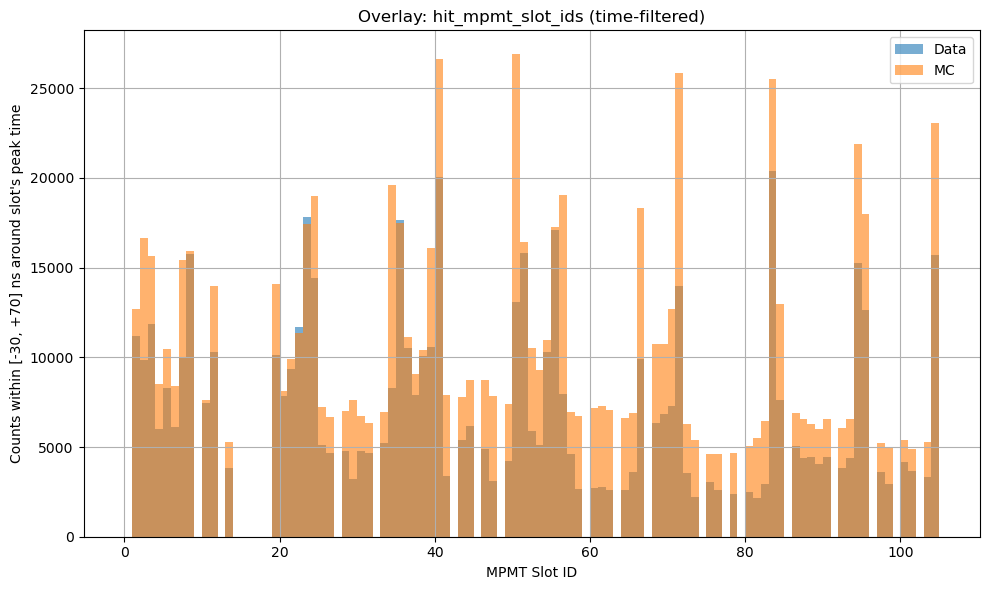

In [11]:
import matplotlib.pyplot as plt
import awkward as ak
import numpy as np

# Define time window around the peak [−30, +70] ns
time_window_low = -30
time_window_high = +70

# --- DATA Filtering ---
slots_data = ak.flatten(df_data["hit_mpmt_slot_ids"])
times_data = ak.flatten(df_data["hit_pmt_times"])

filtered_slots_data = [
    slot for slot, time in zip(slots_data, times_data)
    if not np.isnan(data_peak_times[slot]) and
       (data_peak_times[slot] + time_window_low) <= time <= (data_peak_times[slot] + time_window_high)
]

# --- MC Filtering ---
slots_mc = ak.flatten(df_mc["hit_mpmt_slot_ids"])
times_mc = ak.flatten(df_mc["hit_pmt_times"])

filtered_slots_mc = [
    slot for slot, time in zip(slots_mc, times_mc)
    if not np.isnan(mc_peak_times[slot]) and
       (mc_peak_times[slot] + time_window_low) <= time <= (mc_peak_times[slot] + time_window_high)
]

# --- Plot ---
plt.figure(figsize=(10, 6))
bins = range(0, max(max(filtered_slots_data, default=0), max(filtered_slots_mc, default=0)) + 1)

plt.hist(filtered_slots_data, bins=bins, alpha=0.6, label="Data", histtype='stepfilled')
plt.hist(filtered_slots_mc, bins=bins, alpha=0.6, label="MC", histtype='stepfilled')

plt.xlabel("MPMT Slot ID")
plt.ylabel("Counts within [-30, +70] ns around slot's peak time")
plt.title("Overlay: hit_mpmt_slot_ids (time-filtered)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


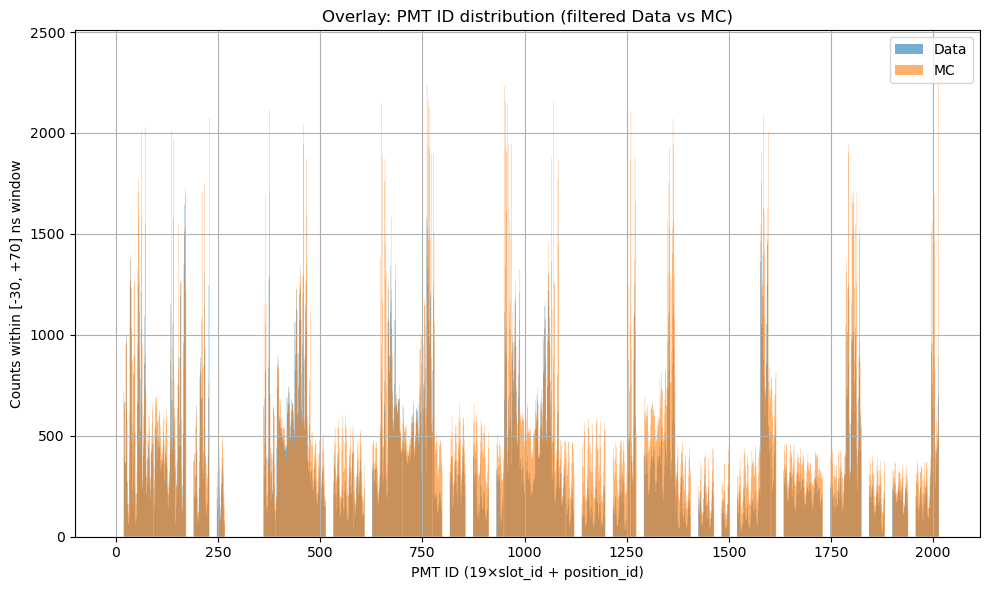

PMT IDs in Data only (not in MC): [19, 190, 247, 361, 532, 627, 817, 874, 931, 1140, 1216, 1292, 1425, 1482, 1520, 1634, 1748, 1843, 1900, 1957]
PMT IDs in MC only (not in Data): [91, 171, 228, 266, 390, 513, 608, 701, 774, 798, 855, 912, 949, 1099, 1121, 1197, 1258, 1259, 1266, 1272, 1273, 1406, 1463, 1501, 1602, 1615, 1729, 1824, 1881, 1938, 2014]


In [12]:
import matplotlib.pyplot as plt
import awkward as ak
import numpy as np

# Time window bounds
time_window_low = -30
time_window_high = +70

# --- Data filtering ---
slots_data = ak.flatten(df_data["hit_mpmt_slot_ids"])
positions_data = ak.flatten(df_data["hit_pmt_position_ids"])
times_data = ak.flatten(df_data["hit_pmt_times"])

filtered_pmt_ids_data = [
    19 * slot + pos
    for slot, pos, time in zip(slots_data, positions_data, times_data)
    if not np.isnan(data_peak_times[slot]) and
       (data_peak_times[slot] + time_window_low) <= time <= (data_peak_times[slot] + time_window_high)
]

# --- MC filtering ---
slots_mc = ak.flatten(df_mc["hit_mpmt_slot_ids"])
positions_mc = ak.flatten(df_mc["hit_pmt_position_ids"])
times_mc = ak.flatten(df_mc["hit_pmt_times"])

filtered_pmt_ids_mc = [
    19 * slot + pos
    for slot, pos, time in zip(slots_mc, positions_mc, times_mc)
    if not np.isnan(mc_peak_times[slot]) and
       (mc_peak_times[slot] + time_window_low) <= time <= (mc_peak_times[slot] + time_window_high)
]

# --- Plot overlay ---
plt.figure(figsize=(10, 6))
bins = range(0,
             max(max(filtered_pmt_ids_data, default=0), max(filtered_pmt_ids_mc, default=0)) + 1)

plt.hist(filtered_pmt_ids_data, bins=bins, alpha=0.6, label="Data", histtype='stepfilled')
plt.hist(filtered_pmt_ids_mc, bins=bins, alpha=0.6, label="MC", histtype='stepfilled')

plt.xlabel("PMT ID (19×slot_id + position_id)")
plt.ylabel("Counts within [-30, +70] ns window")
plt.title("Overlay: PMT ID distribution (filtered Data vs MC)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Exclusive PMT IDs ---
data_pmt_set = set(filtered_pmt_ids_data)
mc_pmt_set = set(filtered_pmt_ids_mc)

in_data_only = sorted(data_pmt_set - mc_pmt_set)
in_mc_only = sorted(mc_pmt_set - data_pmt_set)

print("PMT IDs in Data only (not in MC):", in_data_only)
print("PMT IDs in MC only (not in Data):", in_mc_only)



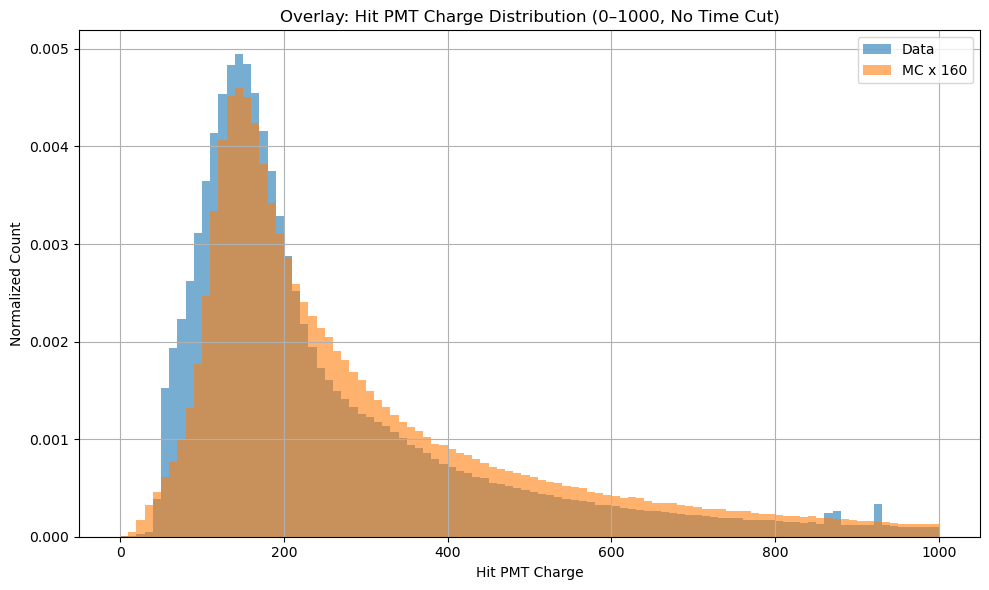

In [13]:
import matplotlib.pyplot as plt
import awkward as ak

# Flatten and scale
charges_data = ak.flatten(df_data["hit_pmt_charges"]) 
charges_mc = ak.flatten(df_mc["hit_pmt_charges"]) *160

# Optional: filter to [0, 1000] range before plotting
charges_data = charges_data[(charges_data >= 0) & (charges_data <= 1000)]
charges_mc = charges_mc[(charges_mc >= 0) & (charges_mc <= 1000)]

# Plot
plt.figure(figsize=(10, 6))
plt.hist(charges_data, bins=100, range=(0, 1000), alpha=0.6, label="Data", histtype='stepfilled', density=True)
plt.hist(charges_mc, bins=100, range=(0, 1000), alpha=0.6, label="MC x 160", histtype='stepfilled', density=True)

plt.xlabel("Hit PMT Charge")
plt.ylabel("Normalized Count")
plt.title("Overlay: Hit PMT Charge Distribution (0–1000, No Time Cut)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


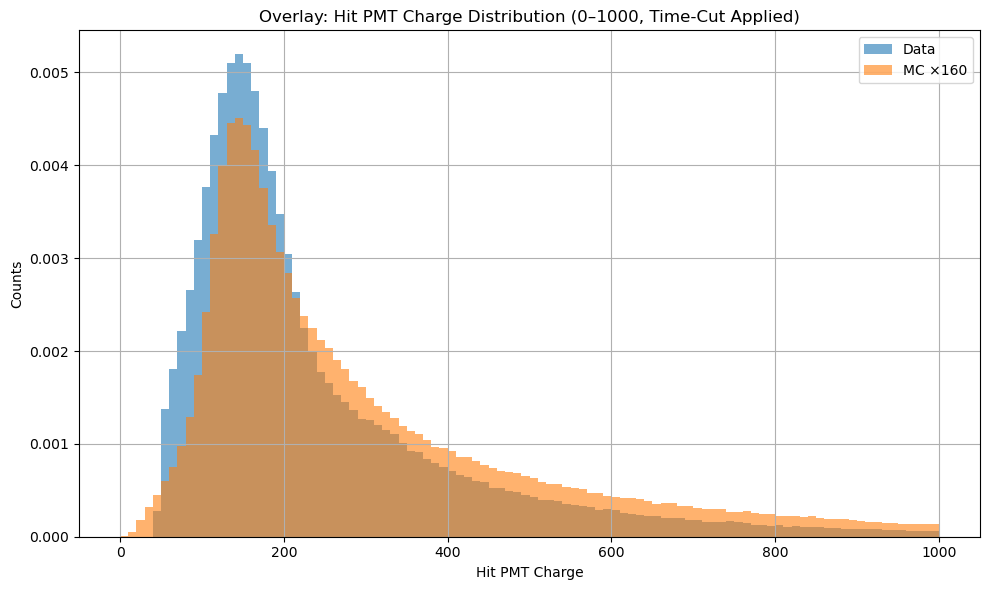

In [14]:
import matplotlib.pyplot as plt
import awkward as ak
import numpy as np

# Define time window
time_window_low = -30
time_window_high = 70

# --- DATA ---
slots_data = ak.flatten(df_data["hit_mpmt_slot_ids"])
times_data = ak.flatten(df_data["hit_pmt_times"])
charges_data = ak.flatten(df_data["hit_pmt_charges"])

# Apply time window cut per slot
filtered_charges_data = [
    charge for slot, time, charge in zip(slots_data, times_data, charges_data)
    if not np.isnan(data_peak_times[slot]) and
       (data_peak_times[slot] + time_window_low) <= time <= (data_peak_times[slot] + time_window_high)
]

# --- MC ---
slots_mc = ak.flatten(df_mc["hit_mpmt_slot_ids"])
times_mc = ak.flatten(df_mc["hit_pmt_times"])
charges_mc = ak.flatten(df_mc["hit_pmt_charges"]) 

filtered_charges_mc = [
    charge * 160 for slot, time, charge in zip(slots_mc, times_mc, charges_mc)
    if not np.isnan(mc_peak_times[slot]) and
       (mc_peak_times[slot] + time_window_low) <= time <= (mc_peak_times[slot] + time_window_high)
]

# Filter to [0, 1000] charge range
filtered_charges_data = [c for c in filtered_charges_data if 0 <= c <= 1000]
filtered_charges_mc = [c for c in filtered_charges_mc if 0 <= c <= 1000]

# --- Plot ---
plt.figure(figsize=(10, 6))
plt.hist(filtered_charges_data, bins=100, range=(0, 1000), alpha=0.6, label="Data", histtype='stepfilled', density=True)
plt.hist(filtered_charges_mc, bins=100, range=(0, 1000), alpha=0.6, label="MC ×160", histtype='stepfilled', density=True)

plt.xlabel("Hit PMT Charge")
plt.ylabel("Counts")
plt.title("Overlay: Hit PMT Charge Distribution (0–1000, Time-Cut Applied)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


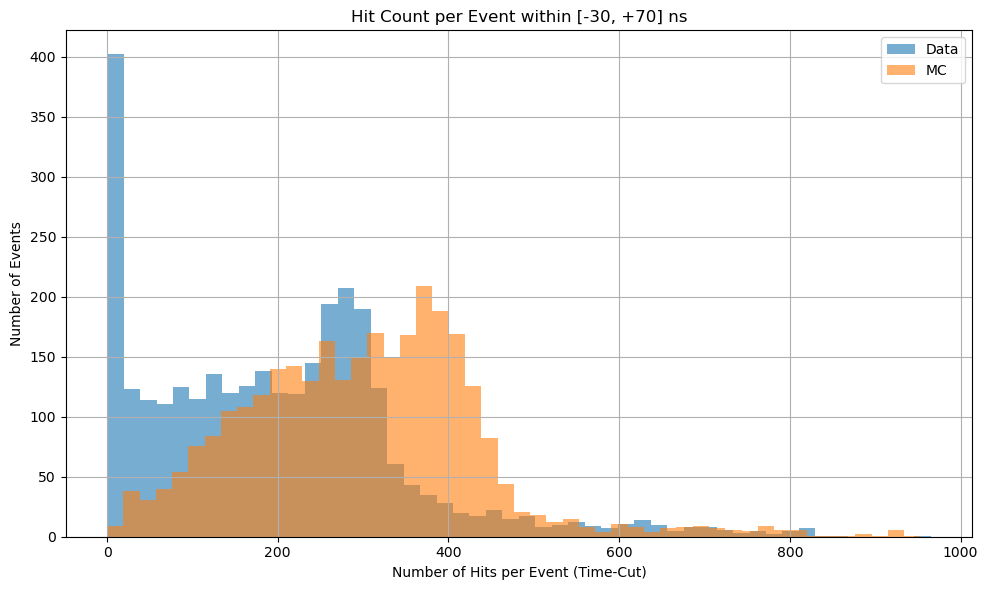

In [15]:
import matplotlib.pyplot as plt
import awkward as ak
import numpy as np

# Time window
time_window_low = -30
time_window_high = 70

# Prepare per-event arrays
slots_data = df_data["hit_mpmt_slot_ids"]
times_data = df_data["hit_pmt_times"]

slots_mc = df_mc["hit_mpmt_slot_ids"]
times_mc = df_mc["hit_pmt_times"]

# Count hits per event
hits_per_event_data = [
    sum(
        (not np.isnan(data_peak_times[slot]) and
         (data_peak_times[slot] + time_window_low) <= time <= (data_peak_times[slot] + time_window_high))
        for slot, time in zip(event_slots, event_times)
    )
    for event_slots, event_times in zip(slots_data, times_data)
]

hits_per_event_mc = [
    sum(
        (not np.isnan(mc_peak_times[slot]) and
         (mc_peak_times[slot] + time_window_low) <= time <= (mc_peak_times[slot] + time_window_high))
        for slot, time in zip(event_slots, event_times)
    )
    for event_slots, event_times in zip(slots_mc, times_mc)
]

# Plot
plt.figure(figsize=(10, 6))
plt.hist(hits_per_event_data, bins=50, alpha=0.6, label="Data", histtype='stepfilled')
plt.hist(hits_per_event_mc, bins=50, alpha=0.6, label="MC", histtype='stepfilled')
plt.xlabel("Number of Hits per Event (Time-Cut)")
plt.ylabel("Number of Events")
plt.title("Hit Count per Event within [-30, +70] ns")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



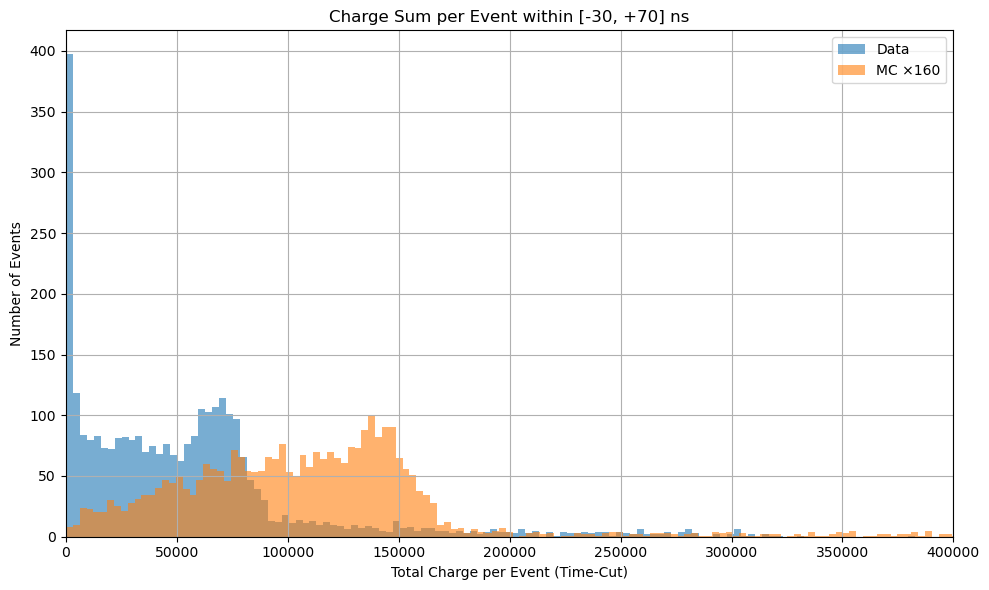

In [16]:
charges_data = df_data["hit_pmt_charges"]
charges_mc = df_mc["hit_pmt_charges"]

# Total charge per event
charge_per_event_data = [
    sum(
        charge
        for slot, time, charge in zip(event_slots, event_times, event_charges)
        if not np.isnan(data_peak_times[slot]) and
           (data_peak_times[slot] + time_window_low) <= time <= (data_peak_times[slot] + time_window_high)
    )
    for event_slots, event_times, event_charges in zip(slots_data, times_data, charges_data)
]

charge_per_event_mc = [
    sum(
        charge * 160
        for slot, time, charge in zip(event_slots, event_times, event_charges)
        if not np.isnan(mc_peak_times[slot]) and
           (mc_peak_times[slot] + time_window_low) <= time <= (mc_peak_times[slot] + time_window_high)
    )
    for event_slots, event_times, event_charges in zip(slots_mc, times_mc, charges_mc)
]

# Plot
plt.figure(figsize=(10, 6))
plt.hist(charge_per_event_data, bins=200, alpha=0.6, label="Data", histtype='stepfilled')
plt.hist(charge_per_event_mc, bins=200, alpha=0.6, label="MC ×160", histtype='stepfilled')
plt.xlabel("Total Charge per Event (Time-Cut)")
plt.ylabel("Number of Events")
plt.title("Charge Sum per Event within [-30, +70] ns")
plt.xlim(0, 400000)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


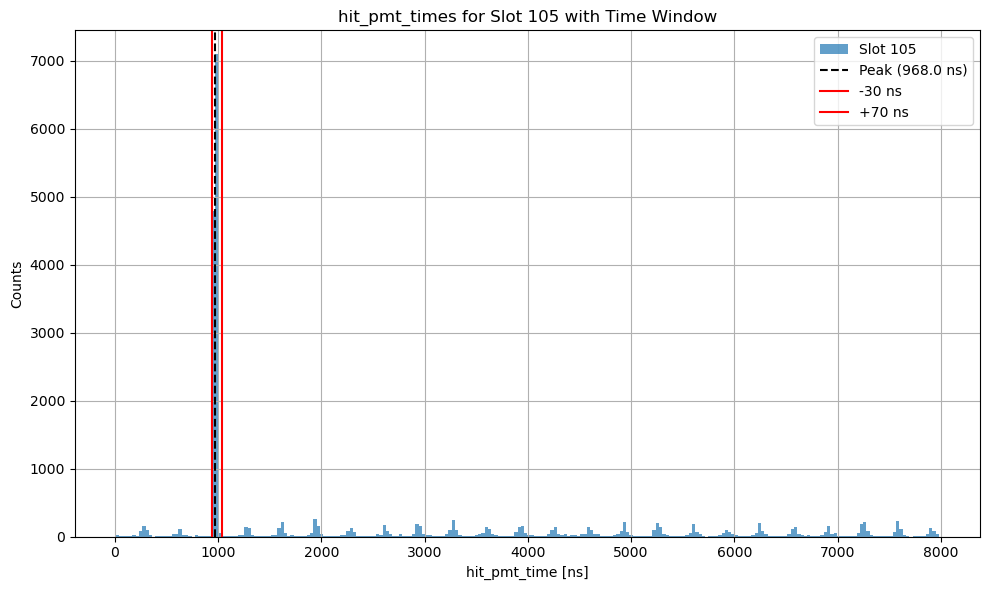

In [17]:
import matplotlib.pyplot as plt
import awkward as ak
import numpy as np

# Flatten relevant arrays
slots = ak.flatten(df_data["hit_mpmt_slot_ids"])
times = ak.flatten(df_data["hit_pmt_times"])

# Slot to filter
target_slot = 105
peak_time = data_peak_times[target_slot]

# Filter hit times for slot 105
slot105_times = [t for s, t in zip(slots, times) if s == target_slot]

# Plot
plt.figure(figsize=(10, 6))
plt.hist(slot105_times, bins=250, alpha=0.7, label="Slot 105", histtype='stepfilled')

# Add vertical lines
plt.axvline(peak_time, linestyle="--", color="black", label=f"Peak ({peak_time:.1f} ns)")
plt.axvline(peak_time - 30, linestyle="-", color="red", label="-30 ns")
plt.axvline(peak_time + 70, linestyle="-", color="red", label="+70 ns")

plt.xlabel("hit_pmt_time [ns]")
plt.ylabel("Counts")
plt.title("hit_pmt_times for Slot 105 with Time Window")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


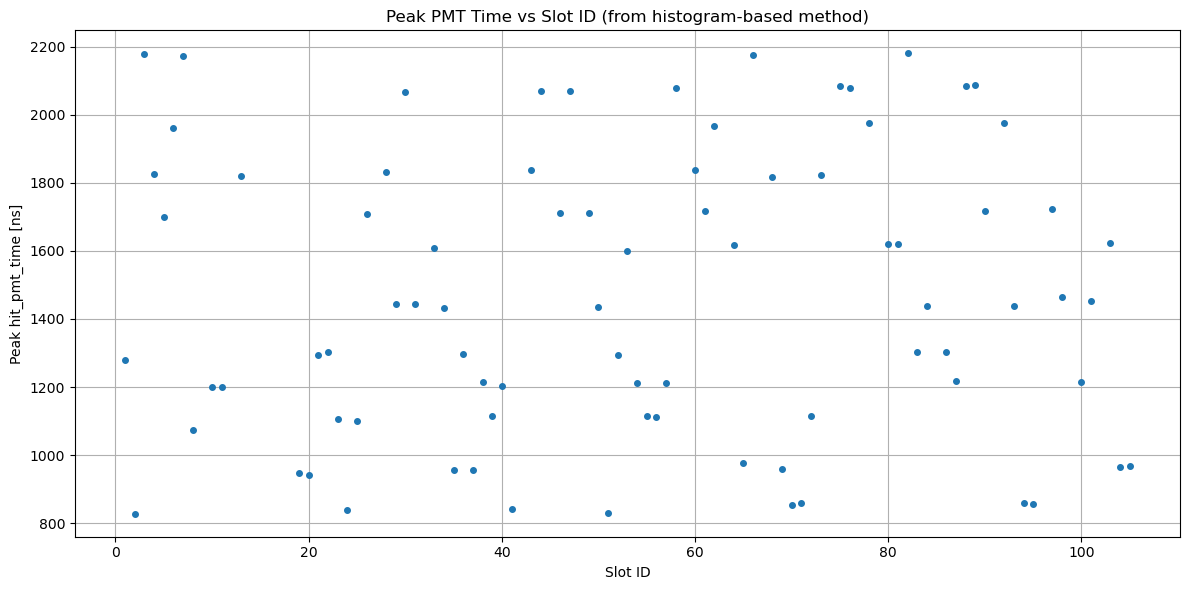

In [18]:
import matplotlib.pyplot as plt
import numpy as np

# Make sure NaNs are filtered
slot_ids = np.arange(len(data_peak_times))
valid_mask = ~np.isnan(data_peak_times)

# Plot
plt.figure(figsize=(12, 6))
plt.plot(slot_ids[valid_mask], data_peak_times[valid_mask], "o", markersize=4)

plt.xlabel("Slot ID")
plt.ylabel("Peak hit_pmt_time [ns]")
plt.title("Peak PMT Time vs Slot ID (from histogram-based method)")
plt.grid(True)
plt.tight_layout()
plt.show()


In [19]:
print("Slot 105 times (count):", len(slot_time_map[105]))
print("Histogram-based peak time:", data_peak_times[105])


Slot 105 times (count): 16896
Histogram-based peak time: 968.0


In [20]:
print("MAX_SLOT_ID:", MAX_SLOT_ID)
print("Length of data_peak_times:", len(data_peak_times))
print("Slot 105 in array:", 105 < len(data_peak_times))


MAX_SLOT_ID: 110
Length of data_peak_times: 110
Slot 105 in array: True


Slot 105: 7408 entries
Peak bin index: 965
Peak time (left edge of bin): 965.0 ns
Bin count at peak: 377
Histogram array (excerpt): [188 253 266 301 350 377 350 231 232 133 135]


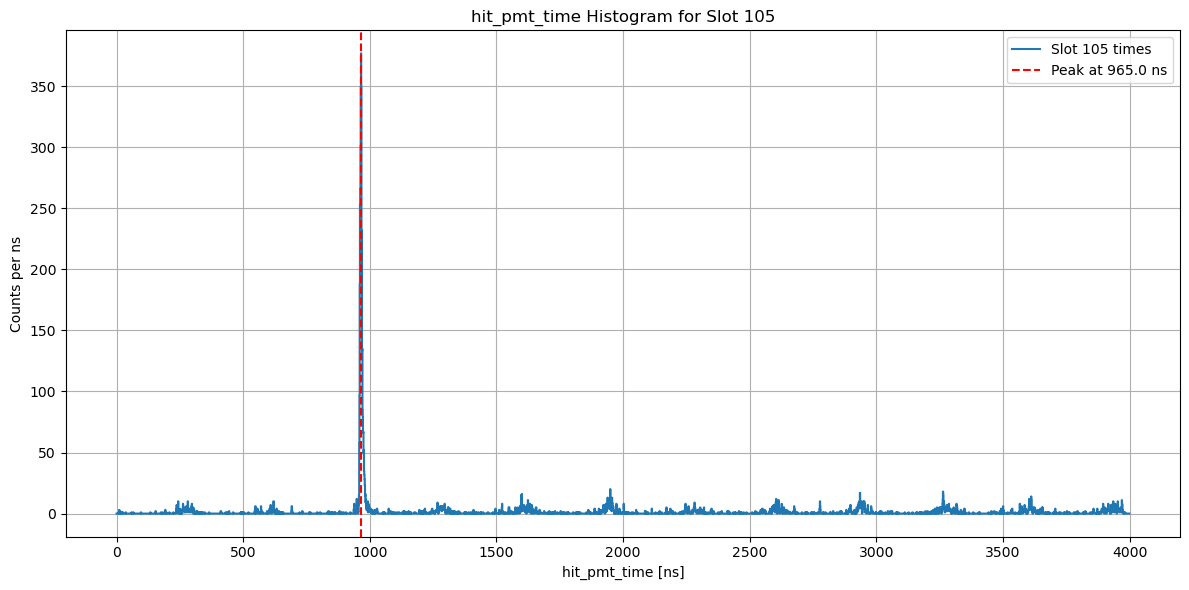

In [21]:
import numpy as np
import awkward as ak
import matplotlib.pyplot as plt

# Flatten full arrays
slots_data = ak.flatten(df_data["hit_mpmt_slot_ids"])
times_data = ak.flatten(df_data["hit_pmt_times"])

# Select times for slot 105 and apply <4000 ns cut
slot = 104
slot105_times = [t for s, t in zip(slots_data, times_data) if s == slot and t < 4000]

# Build histogram (1 ns bins from 0 to 4000)
hist, bin_edges = np.histogram(slot105_times, bins=4000, range=(0, 4000))

# Find peak bin
peak_bin = np.argmax(hist)
peak_time = bin_edges[peak_bin]

# Print debug info
print(f"Slot 105: {len(slot105_times)} entries")
print(f"Peak bin index: {peak_bin}")
print(f"Peak time (left edge of bin): {peak_time:.1f} ns")
print(f"Bin count at peak: {hist[peak_bin]}")
print("Histogram array (excerpt):", hist[peak_bin-5:peak_bin+6])  # show a slice near the peak

# Plot histogram
plt.figure(figsize=(12, 6))
plt.plot(bin_edges[:-1], hist, drawstyle='steps-post', label="Slot 105 times")
plt.axvline(peak_time, color='red', linestyle='--', label=f"Peak at {peak_time:.1f} ns")
plt.xlabel("hit_pmt_time [ns]")
plt.ylabel("Counts per ns")
plt.title("hit_pmt_time Histogram for Slot 105")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [22]:
print(data_peak_times[105])

968.0
